In [1]:
import os
import re

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def show_image(array):
    n = 10
    indices = np.random.randint(len(array), size=n)
    images = array[indices, :]
    fig, axes = plt.subplots(2, 5, figsize=(15,5))
    for i in range(2):
        for j in range(5):
            image = images[i*5+j, :, :]
            axes[i, j].set_title("Index = {}".format(indices[i*5+j]))
            axes[i, j].axis("off")
            axes[i, j].imshow(images[i*5+j].reshape(64, 64), cmap='gray')
    plt.show()

In [8]:
def read_pgm(filename):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    https://zh.wikipedia.org/wiki/PBM%E6%A0%BC%E5%BC%8F
    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
#         print('Header:{}\nWidth:{}\nHeight:{}\nMaxval:{}'.format(header, width, height, maxval))
#         print('len {}'.format(len(header)))
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1',
                            count=int(width) * int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [9]:
def read_mini_mias():
    images_tensor = np.zeros((322, 1024, 1024))
    i = 0
    for dirName, subdirList, fileList in os.walk("data/all-mias/"):
        for fname in fileList:
            if fname.endswith(".pgm"):
                images_tensor[i] = read_pgm("data/all-mias/" + fname)
                i += 1
    return images_tensor

In [10]:
def load_datasets(img_width=64, img_height=64):
    # Read mias dataset
    raw_mias = read_mini_mias()
    mias_images = np.zeros((raw_mias.shape[0], img_width, img_height))
    for i in range(raw_mias.shape[0]):
        mias_images[i] = cv2.resize(raw_mias[i], dsize=(img_width, img_height),
                                    interpolation=cv2.INTER_CUBIC)

#     raw_dx = dataset_reader.read_dx()  # Read DX dataset
#     dx_images = np.zeros((raw_dx.shape[0], img_width, img_width))
#     for i in range(raw_dx.shape[0]):
#         dx_images[i] = cv2.resize(raw_dx[i], dsize=(img_width, img_height),
#                                   interpolation=cv2.INTER_CUBIC)
#     return mias_images, dx_images  # , dental_images
    return mias_images

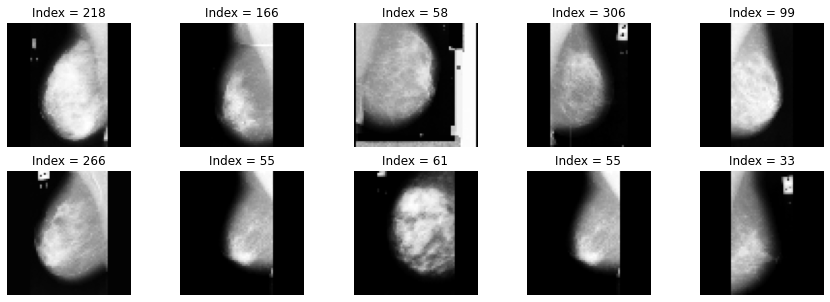

In [13]:
img_width = 64
img_height = 64
mias_images = load_datasets(img_width, img_height)
show_image(mias_images)